In [1]:
import numpy as np
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

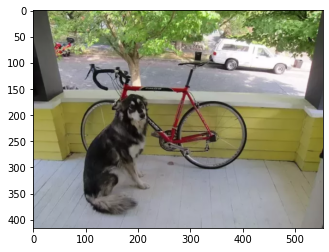

In [2]:
my_img = Image.open("dog-cycle-car.png")

preprocess = transforms.Compose([
    transforms.Resize(416),
    transforms.ToTensor(),
])

img_tensor = preprocess(my_img)[None,:,:,:]
plt.imshow(img_tensor[0].numpy().transpose(1,2,0))

In [4]:
pred_tensor = torch.Tensor([[87.8459, 116.1371,307.0424,289.9205,0.9936,0.9993,1.0000],[258.5947,98.5470,371.7666,143.8070,0.9955,0.8818,7.0000],[67.1713,162.9582,173.7498,338.0852,0.9998,0.9992,16.0000]])
top5_tensor = torch.Tensor([[9.9927e-01, 2.9864e-04, 6.6769e-05, 5.2280e-05, 2.7046e-05],[8.8183e-01, 2.9000e-01, 2.1278e-03, 1.2228e-04, 5.5483e-05],[9.9915e-01, 1.5655e-03, 4.4694e-04, 5.9744e-05, 2.9251e-05]])
idx_tensor = torch.Tensor([[ 1,  8, 16, 13, 30],[7, 2, 5, 8, 6],[16,  1, 15, 53, 18]])

In [11]:
idx_to_name = {}
name_to_idx = {}
with open("data/coco.names") as f:
    i = 0
    for name in f:
        name = name[:-1]
        idx_to_name[i] = name
        name_to_idx[name] = i
        i += 1

In [ ]:
import torch.optim as optim
epsilon = 2./255
delta = torch.zeros_like(img_tensor, requires_grad = True)
opt = optim.SGD([delta], lr = 1e-1)

for t in range(30):
    pred = model(norm(img_tensor+delta))
    loss = -nn.CrossEntropyLoss()(pred,torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon,epsilon)
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage.transform import resize

def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    parser = argparse.ArgumentParser(description='YOLO v3 Detection Module')
   
    parser.add_argument("--images", dest = 'images', help = 
                        "Image / Directory containing images to perform detection upon",
                        default = "imgs", type = str)
    parser.add_argument("--det", dest = 'det', help = 
                        "Image / Directory to store detections to",
                        default = "det", type = str)
    parser.add_argument("--bs", dest = "bs", help = "Batch size", default = 1)
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    
    return parser.parse_args()
    
images = "imgs/dog.jpg"
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()



num_classes = 80
classes = load_classes("data/coco.names")



#Set up the neural network
print("Loading network.....")
model = Darknet("cfg/yolov3.cfg")
derivatives = model.load_weights("yolov3.weights")
print("Network successfully loaded")

model.net_info["height"] = 416#args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()


#Set the model in evaluation mode
model.eval()

read_dir = time.time()
#Detection phase
try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists("det"):
    os.makedirs("det")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0


if CUDA:
    im_dim_list = im_dim_list.cuda()
j=0
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
#load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    #with torch.no_grad():
    batch.requires_grad_(True)
    prediction, myAs, mySigs = model(Variable(batch, requires_grad = True), CUDA)
    #print(grads)
    #prediction.backward()
    #print("\nPrediction")
    #print(prediction.shape)
    ders = []
    #print("\nA's")
    #for tens in myAs:
       #print(tens.shape)
    fincam = np.zeros((416,416))
    f,ax = plt.subplots(1,2, figsize=(20,5))
    for i in range(0,3):
        myA = (myAs[3*i+0] + myAs[3*i+1] + myAs[3*i+2])/3
        #myA = max(myAs[0] , myAs[1] , myAs[2])#/3
        A = torch.sum(torch.sum(myA))
        #print("\nDerivatives")
        for tens in derivatives:
            #print(tens.shape)
            ders.append(float(torch.sum(tens)))
        mySigs[i] = torch.mean(mySigs[i], 0)
        #print("\nShape of mySigs:")
        #print(mySigs[0].shape)
        coeff_1 = 1 - 2 * mySigs[i]
        #print("\nShape of coeff_1:")
        #print(coeff_1.shape)
        coeff_2 = 6 * mySigs[i]**2 - 6 * mySigs[i] + 1
        #print("\nShape of coeff_2:")
        #print(coeff_2.shape)
        numerator = coeff_1 * (ders[i]**2)
        #print("\nShape of numerator:")
        #print(numerator.shape)
        denominator = 2*numerator + (coeff_2 * A * (ders[i]**3))
        #print("\nShape of denominator:")
        #print(denominator.shape)
        alpha = numerator/denominator
        #print("\nShape of alpha:")
        #print(alpha.shape)

        alpha_ = alpha.to('cpu')
        cam = alpha_.numpy()
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = resize(cam, (416,416))
        cam = (cam*-1.0) + 1.0
        fincam += cam
    cam_heatmap = cv2.applyColorMap(np.uint8(255*fincam), cv2.COLORMAP_JET)
    cam_heatmap = np.array(cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    imgplot = ax[0].imshow(cam_heatmap)
    cam_heatmap = cam_heatmap/255.0
    img = resize(loaded_ims[0], (416,416))
    fin = (img*0.7) + (cam_heatmap*0.3)
    plt.axis("off")
    imgplot = ax[1].imshow(fin)
    plt.savefig("heat/Img" + str(j), dpi=600)
    plt.close(fig)
    j += 1
    prediction, p1, p2 = write_results(prediction, derivatives, confidence, num_classes, nms_conf = nms_thesh)
    #print(prediction)
    #print(p1)
    #print(p2)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2



output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
    
output_recast = time.time()
class_load = time.time()
colors = pkl.load(open("pallete", "rb"))

draw = time.time()


def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("det",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))


end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()
    


Loading network.....
Network successfully loaded


RuntimeError: CUDA error: device-side assert triggered

In [5]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered